In [1]:
import os
import time
import itertools

from torchvision.transforms import v2
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm
from IPython import display
import gc 

%load_ext autoreload

%autoreload 2
from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
torchvision.disable_beta_transforms_warning()

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <38796DC6-8F33-3A89-BBAA-5FC71F99817A> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints a

In [2]:
def data_split(test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds, val_prop=0.1):
    assert 0 <= test_prop <= 1, 0 <= val_prop <= 1
    assert 0 <= fold_idx < nfolds, f'fold_idx was set to {fold_idx} but must be in the range [0, {nfolds - 1} = (nfolds - 1)]'
    batch_data = dsl[dsl['batch_id_x'] == batch_id]
    if nfolds == 1:
        val_prop = val_prop
    else:
        val_prop = 1 / nfolds
    
    if test_module_ids is not None:
        test_data = batch_data[batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        train_data = batch_data[~batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        # assert len(test_data) > 0 and len(train_data) > 0, 'At least one module_id in test_modules={test_module_ids} is invalid.'        
        test_idx = test_data.index.values

        ntrain = len(train_data)
        nval = int(ntrain * val_prop)
        
        # nbdd = int((ntrain - nval) * boundary_prop / 2)
        left_val_idx = int(nval * fold_idx)
        right_val_idx = int(nval * (fold_idx + 1))
        
        val_idx = train_data[left_val_idx: right_val_idx].index.values
        
        train_idx = np.append(
            train_data[:max(0, left_val_idx - nval)].index.values,
            train_data[right_val_idx + nval:].index.values
        )
    else:
        batch_data = batch_data.sort_values(by = 'frame_unix_t')
        test_split = int(len(batch_data) * test_prop)
        ntrain = len(batch_data) - test_split
        val_split = int(ntrain * val_prop)
        boundary_cnt = int((len(batch_data) - val_split) * boundary_prop)
        
        test_idx = batch_data[:test_split].index.values
        val_idx = batch_data[test_split: test_split + val_split].index.values
        train_idx = batch_data[test_split + val_split + boundary_cnt:].index.values
    assert len(set(val_idx).intersection(set(train_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'
    assert len(set(train_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between train_idx and train_idx'
    assert len(set(val_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'

    return test_idx, val_idx, train_idx

def get_windowed_test_val_train_indices(test_prop, boundary_prop=0.2, test_module_ids=None, fold_idx=0, nfolds=5):
    test_indices = np.array([], dtype=np.int64)
    val_indices = np.array([], dtype=np.int64)
    train_indices = np.array([], dtype=np.int64)

    for batch_id in dsl['batch_id_x'].unique():
        test_idx, val_idx, train_idx = data_split(
            test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds
        )
        test_indices = np.concatenate((test_indices, test_idx))
        val_indices = np.concatenate((val_indices, val_idx))
        train_indices = np.concatenate((train_indices, train_idx))
    return test_indices, val_indices, train_indices


def get_shuffled_test_val_train_indices(test_prop, val_prop):
    dataset_size = len(dsl)
    dataset_indices = np.arange(dataset_size)
    
    np.random.shuffle(dataset_indices)
    
    # Test / Train split
    test_split_index = int(np.floor(test_prop * dataset_size))
    trainset_indices, test_idx = dataset_indices[test_split_index:], dataset_indices[:test_split_index]
    
    # Train / Val split
    trainset_size = len(trainset_indices)
    val_split_index = int(np.floor(val_prop * trainset_size))
    train_idx, val_idx = trainset_indices[val_split_index:], trainset_indices[:val_split_index]
    return test_idx, val_idx, train_idx

def preview_frames(data_loader, frame_time=0.01):
    try:
        for X, Y in data_loader:
            for img in X:
                plt.imshow(img.reshape((32,32)), vmin=-2, vmax=2, cmap='icefire')
                plt.show()
                plt.close()
                time.sleep(frame_time)
                display.clear_output(wait=True)
    except KeyboardInterrupt:
        plt.close()
    finally:
        plt.close()
        gc.collect()

def get_dataset_preview(dataset, idxs, title, sample_idxs, nrows, ncols, ax, idx_to_plot=0):
    imgs = np.zeros((nrows * 32, ncols * 32))
    assert len(sample_idxs) == nrows * ncols
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        X, Y = dataset[idx]
        curr = X[idx_to_plot].reshape(32,32)
        imgs[row*32:(row+1)*32, col*32:(col+1)*32] = curr.numpy()
    ax.imshow(imgs, vmin=-1, vmax=1, cmap='icefire')
    ax.set_title(title)

def get_pixel_dist(dataset, idxs, title, sample_idxs, ax, idx_to_plot=0):
    imgs = np.empty((nsamples, 32, 32))
    for i, idx in enumerate(sample_idxs):
        X, Y = dataset[idx]
        curr = X[idx_to_plot].reshape(32,32)
        imgs[i] = curr.numpy()
    sns.histplot(imgs.ravel(), stat='density', ax=ax, label=idx_to_plot, binrange=[-1,1])
    ax.legend()
    ax.set_title(title)


def get_cloudy_stats(data, idx):
    filtered_data = data.iloc[idx]
    clear_data = filtered_data.loc[filtered_data['label'] == 'clear_night_sky']
    cloudy_data = filtered_data.loc[filtered_data['label'] == 'not_clear_cloudy']
    prop_clear = len(clear_data) / len(filtered_data)
    prop_cloudy = len(cloudy_data) / len(filtered_data)
    return len(cloudy_data), prop_cloudy


def print_class_dist(data, idx, name):
    filtered_data = data.iloc[idx]
    ncloudy, prop_cloudy = get_cloudy_stats(data, idx)
    unique_module_ids = list(np.sort(filtered_data["module_id"].unique()))
    print(f'Percent cloudy (in {name}) = {100 * prop_cloudy:.3f}% ({ncloudy} / {len(filtered_data)}); '
          f'Unique module_ids: {unique_module_ids}')

def get_fold_class_dists(nfolds):
    df = pd.DataFrame(columns=['Fold_idx', 'dataset', 'ncloudy', 'cloudy_prop', 'size'])
    for fold_idx in range(nfolds):
        # Get data splits
        test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
            test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
        )
        print(f'Fold {fold_idx}')
        for idxs, name in zip([test_idx, val_idx, train_idx], ['test', 'val', 'train']):
            ncloudy, cloudy_prop = get_cloudy_stats(dsl, idxs)
            row = [fold_idx, name, ncloudy, cloudy_prop, len(idxs)]
            df.loc[len(df)] = row
            print('\t', end='')
            print_class_dist(dsl, idxs, name)
    print_class_dist(dsl, dsl.index, 'overall')

In [3]:
test_prop = 0.3
nfolds = 5
# boundary_prop = 0.1 # Proportion of data to discard between the validation and train_proportions (time)
batch_size = 128
random_seed = 35


# Creating the datasets
# mean = [7.4, 0, 0]
# std = [5.5, 60, 75]

# mean = [7.4, 0, 0, 7.4]
# std = [5.5, 60, 75, 5.5]

mean = [7.4, 7.4]
std = [5.5, 5.5]

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    # v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.5, 0.5)),
    v2.Normalize(mean=mean, std=std),
    # v2.ColorJitter(None, 0.1, None, None),
    v2.ToDtype(torch.float),
    
    # v2.RandomAdjustSharpness(1.2)
])

# Create test/train split
target_transform = v2.Compose([
    v2.ToTensor(),
    # v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.5, 0.5)),
    v2.Normalize(mean=mean, std=std),
    v2.ToDtype(torch.float),
])

train_labeled_data = CloudDetectionTrain(
    transform=transform
)
test_labeled_data = CloudDetectionTrain(
    target_transform=target_transform
)

dsl = train_labeled_data.dsl_df
dataset_size = len(dsl)

# Split data
all_idxs = np.arange(dataset_size)
y_labels = dsl['label'].map(
    {
        "clear_night_sky": 0,
        "not_clear_cloudy": 1
    }
)

train_split_idxs, test_split_idxs, y_train, y_test = train_test_split(
    all_idxs,
    y_labels,
    test_size=test_prop,
    random_state=random_seed,
    stratify=y_labels
)

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_split_idxs)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_split_idxs)
)


# Get dataset stats
print(
    f'test_prop (of dataset) = {100 * len(test_split_idxs) / dataset_size:.2f}%\n'
    f'train_prop (of dataset) = {100 * len(train_split_idxs) / dataset_size:.2f}%\n'
)
print_class_dist(dsl, test_split_idxs, 'test')
print_class_dist(dsl, train_split_idxs, 'train')
print_class_dist(dsl, dsl.index, 'overall')

test_prop (of dataset) = 30.00%
train_prop (of dataset) = 70.00%

Percent cloudy (in test) = 53.955% (3765 / 6978); Unique module_ids: [1, 3, 254]
Percent cloudy (in train) = 53.965% (8786 / 16281); Unique module_ids: [1, 3, 254]
Percent cloudy (in overall) = 53.962% (12551 / 23259); Unique module_ids: [1, 3, 254]


Fold 0:
  Train: index=[    0     2     3 ... 16276 16279 16280]
  Val:  index=[    1     4     8 ... 16275 16277 16278]
Fold 1:
  Train: index=[    0     1     2 ... 16277 16278 16280]
  Val:  index=[    6     7    27 ... 16271 16276 16279]
Fold 2:
  Train: index=[    0     1     2 ... 16278 16279 16280]
  Val:  index=[    5    10    11 ... 16266 16268 16273]
Fold 3:
  Train: index=[    0     1     2 ... 16277 16278 16279]
  Val:  index=[    3     9    14 ... 16261 16272 16280]
Fold 4:
  Train: index=[    1     3     4 ... 16278 16279 16280]
  Val:  index=[    0     2    12 ... 16269 16270 16274]


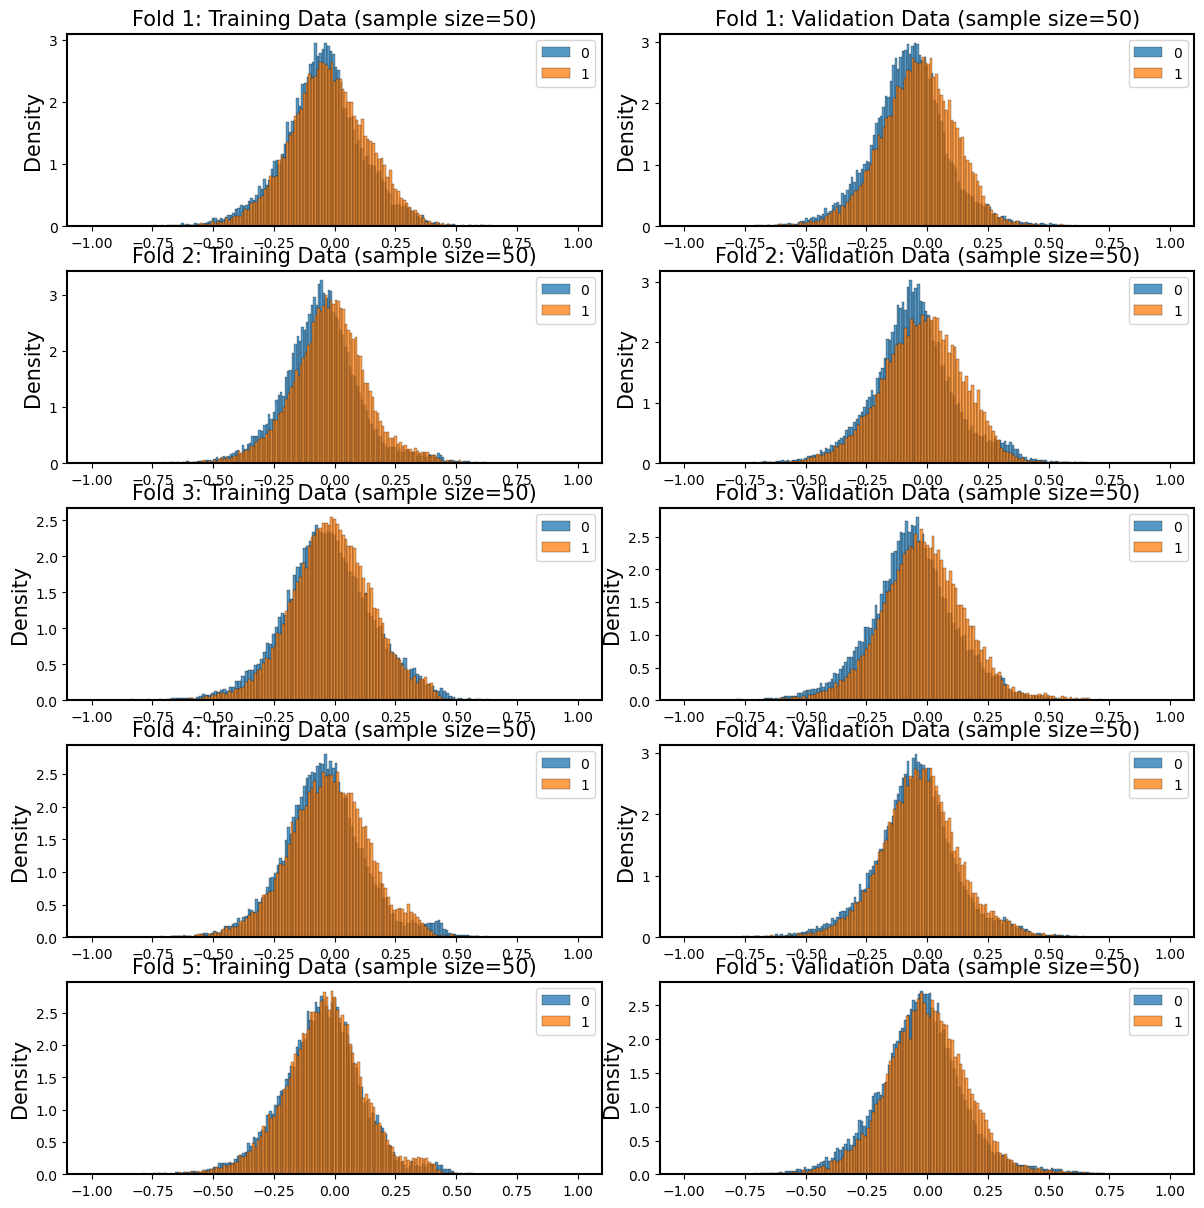

In [4]:
fig, axs = plt.subplots(nfolds, 2, figsize=(12, 12))
fig.tight_layout()

skf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=random_seed)

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_split_idxs, y_train)):
    print(f"Fold {fold_idx}:")
    print(f"  Train: index={train_idx}")
    print(f"  Val:  index={val_idx}")

    nrows, ncols = 5, 10
    
    nsamples = nrows * ncols
    train_sample_idxs = np.random.choice(train_idx, nsamples, replace=False)
    val_sample_idxs = np.random.choice(val_idx, nsamples, replace=False)

    if len(train_sample_idxs) < nsamples:
        print('Not enough training data')
        break
    elif len(val_sample_idxs) < nsamples:
        print('Not enough validation data')
        break
    
    get_pixel_dist(
        train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
        sample_idxs=train_sample_idxs, ax=axs[fold_idx][0], idx_to_plot=0
    )
    get_pixel_dist(
        train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
        sample_idxs=train_sample_idxs, ax=axs[fold_idx][0], idx_to_plot=1
    )
    # get_pixel_dist(
    #     train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
    #     sample_idxs=train_sample_idxs, ax=axs[fold_idx][0], idx_to_plot=2
    # )
    # get_pixel_dist(
    #     train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
    #     sample_idxs=train_sample_idxs, ax=axs[fold_idx][0], idx_to_plot=3
    # )

    get_pixel_dist(
        test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
        sample_idxs=val_sample_idxs, ax=axs[fold_idx][1], idx_to_plot=0
    )
    get_pixel_dist(
        test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
        sample_idxs=val_sample_idxs, ax=axs[fold_idx][1], idx_to_plot=1
    )
    # get_pixel_dist(
    #     test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
    #     sample_idxs=val_sample_idxs, ax=axs[fold_idx][1], idx_to_plot=2
    # )
    # get_pixel_dist(
    #     test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
    #     sample_idxs=val_sample_idxs, ax=axs[fold_idx][1], idx_to_plot=3
    # )
    
    # get_dataset_preview(
    #     train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
    #     nrows=nrows, ncols=ncols, ax=axs[fold_idx][0], idx_to_plot=1
    # )
    # get_dataset_preview(
    #     test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
    #     nrows=nrows, ncols=ncols, ax=axs[fold_idx][1], idx_to_plot=1
    # )
plt.show(fig)
plt.close()

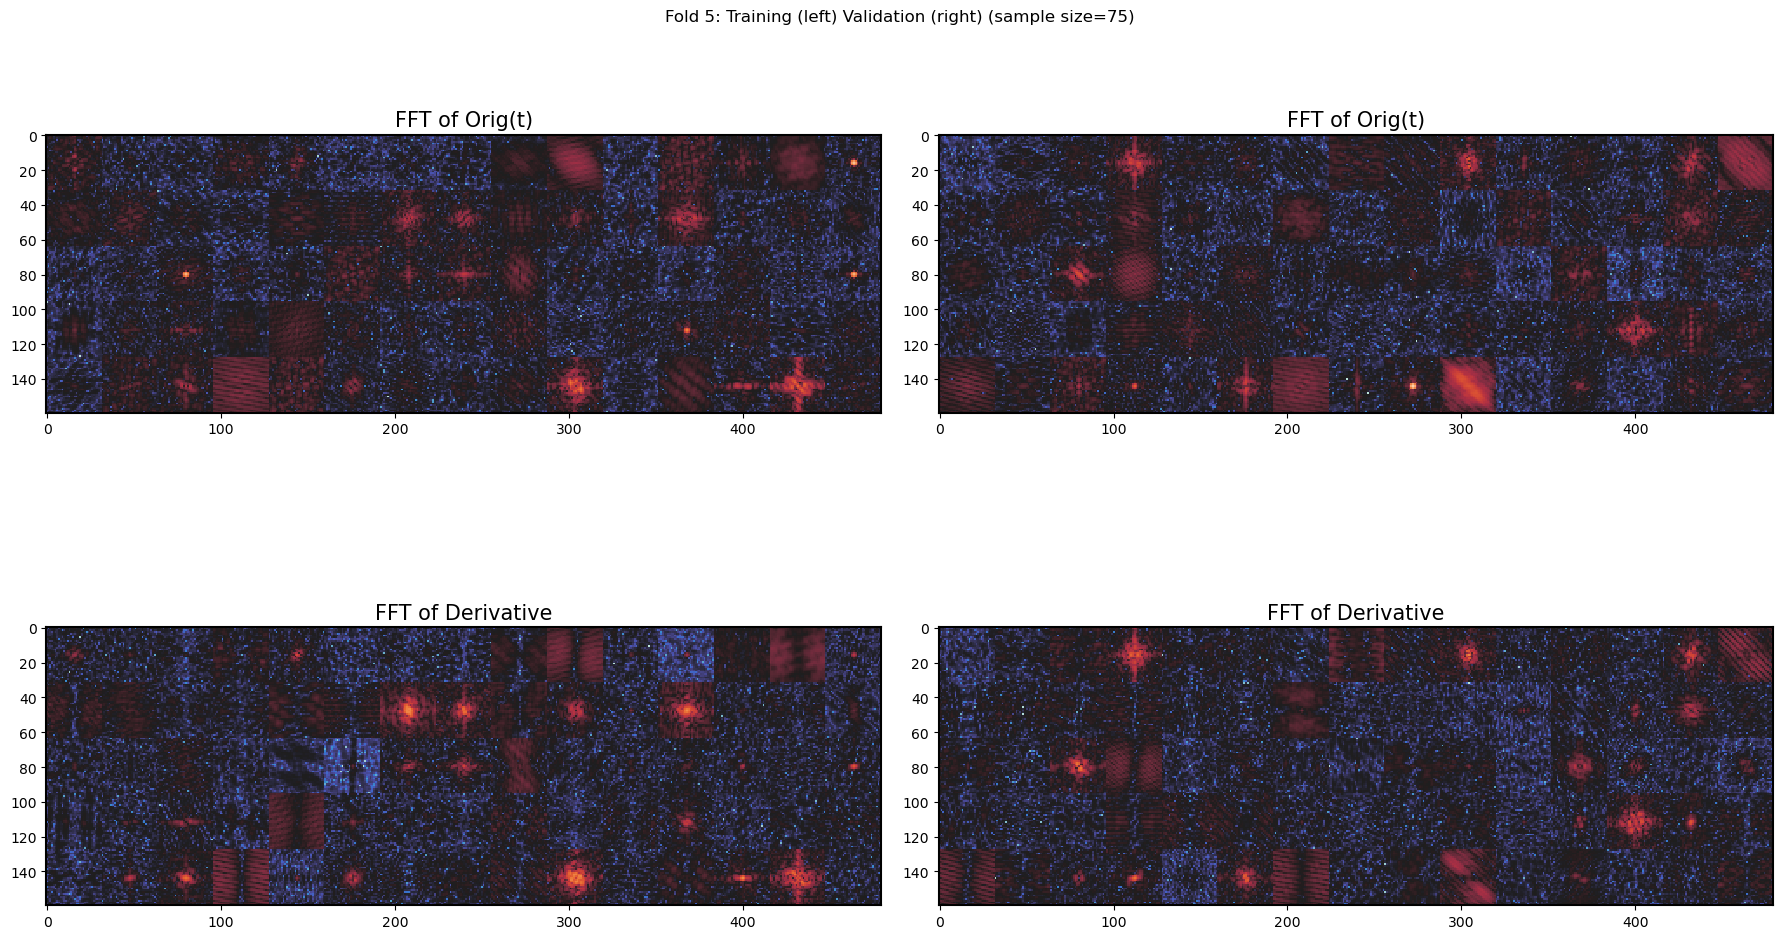

In [5]:
nrows, ncols = 5, 15
data_fig, data_axs = plt.subplots(2, 2, figsize=(ncols*1.2, nrows*2))
data_fig.tight_layout()

nsamples = nrows * ncols
train_sample_idxs = np.random.choice(train_idx, nsamples, replace=False)
val_sample_idxs = np.random.choice(val_idx, nsamples, replace=False)

if len(train_sample_idxs) < nsamples:
    print('Not enough training data')
elif len(val_sample_idxs) < nsamples:
    print('Not enough validation data')

# img_types = {
#     0: 'FFT of Derivative',
#     1: 'Orig(t) @ 3ms',
#     2: 'Orig(t) - Orig(t-60s)',
#     3: 'FFT of Orig(t)'
# }

img_types = {
    0: 'FFT of Derivative',
    1: 'FFT of Orig(t)'
}

data_fig.suptitle(f'Fold {fold_idx + 1}: Training (left) Validation (right) (sample size={nrows*ncols})', y=1.02)
for img_type_idx in range(1, 3):
    img_type_idx = img_type_idx % 2
    img_type = img_types[img_type_idx]
    get_dataset_preview(
        test_labeled_data, train_idx, title=img_type,
        sample_idxs=train_sample_idxs, nrows=nrows, ncols=ncols, ax=data_axs[img_type_idx - 1][0], idx_to_plot=img_type_idx
    )
    get_dataset_preview(
        test_labeled_data, val_idx, title=img_type,
        sample_idxs=val_sample_idxs, nrows=nrows, ncols=ncols, ax=data_axs[img_type_idx - 1][1], idx_to_plot=img_type_idx
    )
plt.show(data_fig)
plt.close(data_fig)

In [6]:
learning_rate = 0.001
weight_decay = 1e-5
epochs = 10
nfolds = 4
gamma = 0.9

skf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=random_seed)
def do_cross_validation(test_prop, nfolds):
    test_loader = None
    validation_accuracies = []
    trainers = []
    dsl = train_labeled_data.dsl_df
    try:
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_split_idxs, y_train)):
            # print(f"  Train: index={train_idx}")
            # print(f"  Val:  index={val_idx}")
            
            # Make dataloaders
            kfold_train_loader = torch.utils.data.DataLoader(
              dataset=train_labeled_data,
              batch_size=batch_size,
              sampler=torch.utils.data.SubsetRandomSampler(train_idx)
            )
            
            kfold_val_loader = torch.utils.data.DataLoader(
              dataset=test_labeled_data,
              batch_size=batch_size,
              sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
            )

            ##### Create model
            model = CloudDetection()
            # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
            
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            loss_fn = nn.CrossEntropyLoss()
            
            trainer = Trainer(
                model, optimizer, loss_fn, kfold_train_loader, kfold_val_loader,
                epochs=epochs, gamma=gamma, do_summary=False,
            )
            print(f'Doing Fold {fold_idx + 1} of {nfolds}')
            trainer.train(make_train_logs=True, write_plots=False, fold_idx=fold_idx + 1)

            # Print stats
            print(f'Fold {fold_idx + 1} Class Stats')
            print_class_dist(dsl, val_idx, 'val')
            print_class_dist(dsl, train_idx, 'train')

            # Plot sample of data
            nrows, ncols = 5, 15
            data_fig, data_axs = plt.subplots(2, 2, figsize=(ncols*1.2, nrows*2))
            data_fig.tight_layout()
            
            nsamples = nrows * ncols
            train_sample_idxs = np.random.choice(train_idx, nsamples, replace=False)
            val_sample_idxs = np.random.choice(val_idx, nsamples, replace=False)
            
            if len(train_sample_idxs) < nsamples:
                print('Not enough training data')
            elif len(val_sample_idxs) < nsamples:
                print('Not enough validation data')
            
            # img_types = {
            #     0: 'FFT of Derivative',
            #     1: 'Orig(t) @ 3ms',
            #     2: 'Orig(t) - Orig(t-60s)',
            #     3: 'FFT of Orig(t)'
            # }
            
            img_types = {
                0: 'FFT of Derivative',
                1: 'FFT of Orig(t)'
            }
            
            data_fig.suptitle(f'Fold {fold_idx + 1}: Training (left) Validation (right) (sample size={nrows*ncols})', y=1.02)
            for img_type_idx in range(1, 3):
                img_type_idx = img_type_idx % 2
                img_type = img_types[img_type_idx]
                get_dataset_preview(
                    test_labeled_data, train_idx, title=img_type,
                    sample_idxs=train_sample_idxs, nrows=nrows, ncols=ncols, ax=data_axs[img_type_idx - 1][0], idx_to_plot=img_type_idx
                )
                get_dataset_preview(
                    test_labeled_data, val_idx, title=img_type,
                    sample_idxs=val_sample_idxs, nrows=nrows, ncols=ncols, ax=data_axs[img_type_idx - 1][1], idx_to_plot=img_type_idx
                )
            plt.show(data_fig)
            plt.close(data_fig)
            # nrows, ncols = 5, 15
            # data_fig, data_axs = plt.subplots(4, 2, figsize=(ncols*1.2, nrows*2))
            # data_fig.tight_layout()
            
            # nsamples = nrows * ncols
            # train_sample_idxs = np.random.choice(train_idx, nsamples, replace=False)
            # val_sample_idxs = np.random.choice(val_idx, nsamples, replace=False)
            
            # if len(train_sample_idxs) < nsamples:
            #     print('Not enough training data')
            # elif len(val_sample_idxs) < nsamples:
            #     print('Not enough validation data')
            
            # img_types = {
            #     0: 'FFT of Derivative',
            #     1: 'Orig(t) @ 3ms',
            #     2: 'Orig(t) - Orig(t-60s)',
            #     3: 'FFT of Orig(t)'
            # }
            # data_fig.suptitle(f'Fold {fold_idx + 1}: Training (left) Validation (right) (sample size={nrows*ncols})', y=1.02)
            # for img_type_idx in range(1, 5):
            #     img_type_idx = img_type_idx % 4
            #     img_type = img_types[img_type_idx]
            #     get_dataset_preview(
            #         test_labeled_data, train_idx, title=img_type,
            #         sample_idxs=train_sample_idxs, nrows=nrows, ncols=ncols, ax=data_axs[img_type_idx - 1][0], idx_to_plot=img_type_idx
            #     )
            #     get_dataset_preview(
            #         test_labeled_data, val_idx, title=img_type,
            #         sample_idxs=val_sample_idxs, nrows=nrows, ncols=ncols, ax=data_axs[img_type_idx - 1][1], idx_to_plot=img_type_idx
            #     )
            # plt.show(data_fig)
            # plt.close(data_fig)
            
            average_validation_accuracies_in_last_5_epochs = trainer.training_log['val']['acc'][-5:]
            validation_accuracies.append(average_validation_accuracies_in_last_5_epochs)
    
            # Cleanup
            del trainer
    except Exception as e:
        raise e
    finally:
        print(f'Average validation accuracy: {np.mean(validation_accuracies)}')
        return validation_accuracies

Doing Fold 1 of 4


Epoch 1


  0%|          | 0/96 [00:00<?, ?batches/s]

Keyboard Interrupt: Stopping training
Fold 1 Class Stats
Percent cloudy (in val) = 46.770% (1904 / 4071); Unique module_ids: [1, 3, 254]
Percent cloudy (in train) = 47.527% (5803 / 12210); Unique module_ids: [1, 3, 254]


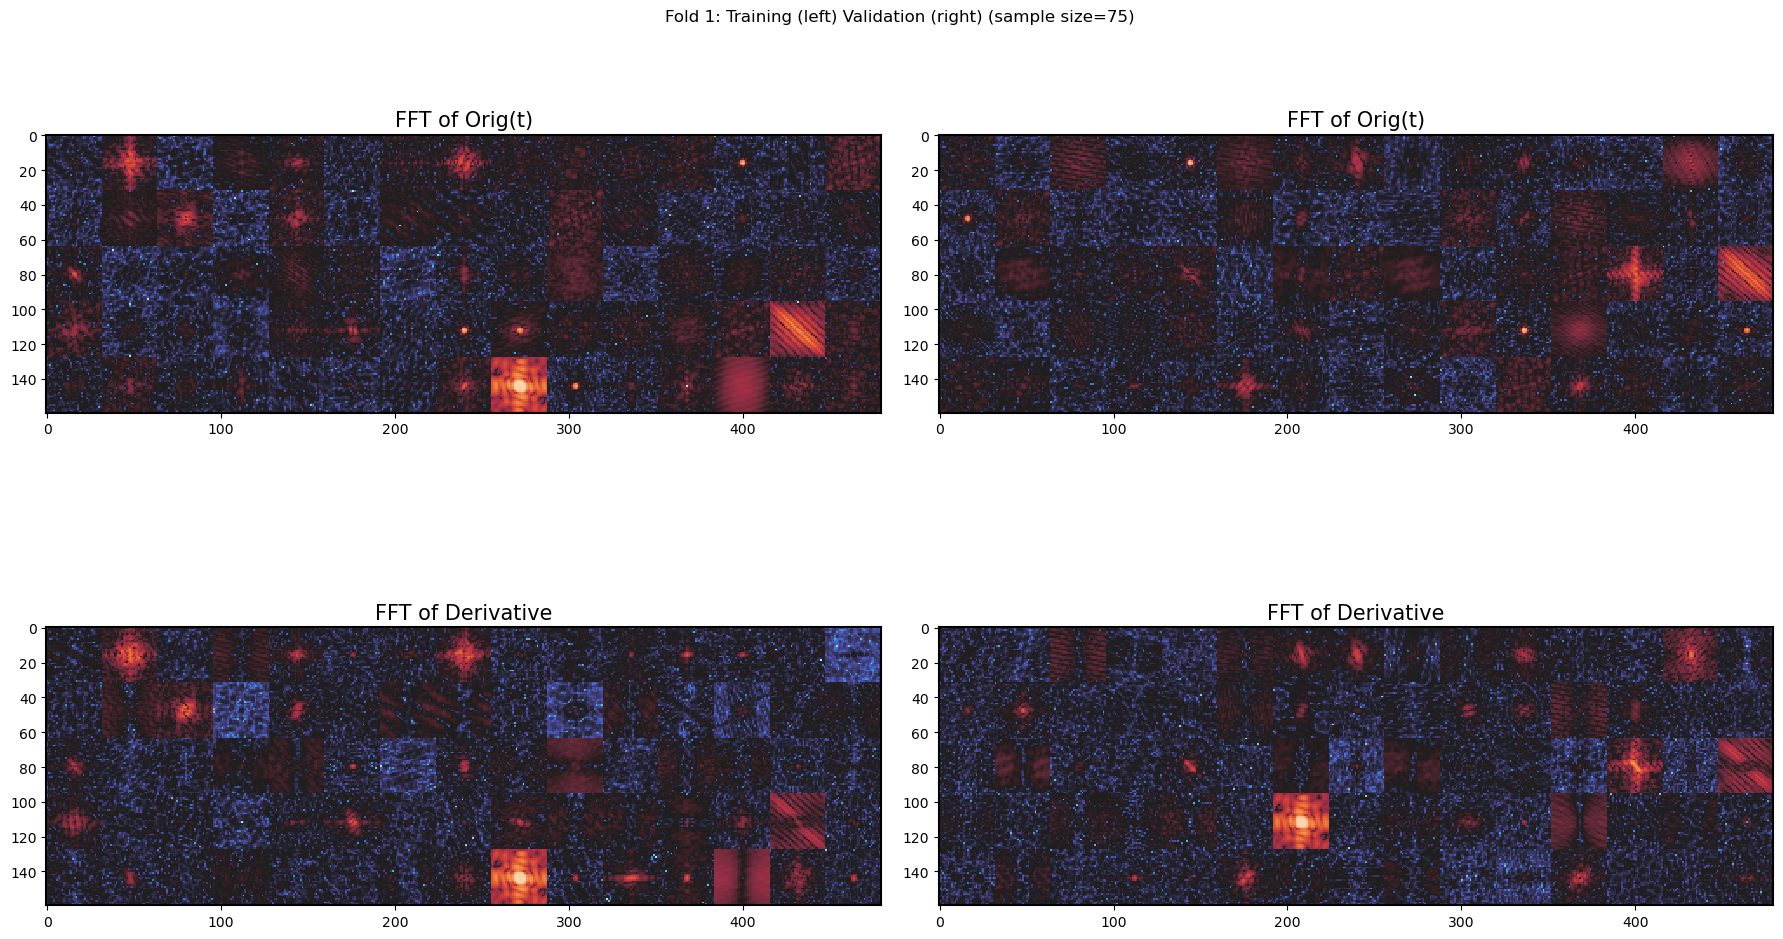

Doing Fold 2 of 4


Epoch 1


  0%|          | 0/96 [00:00<?, ?batches/s]

Keyboard Interrupt: Stopping training
Fold 2 Class Stats
Percent cloudy (in val) = 48.649% (1980 / 4070); Unique module_ids: [1, 3, 254]
Percent cloudy (in train) = 46.900% (5727 / 12211); Unique module_ids: [1, 3, 254]
Average validation accuracy: nan


/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


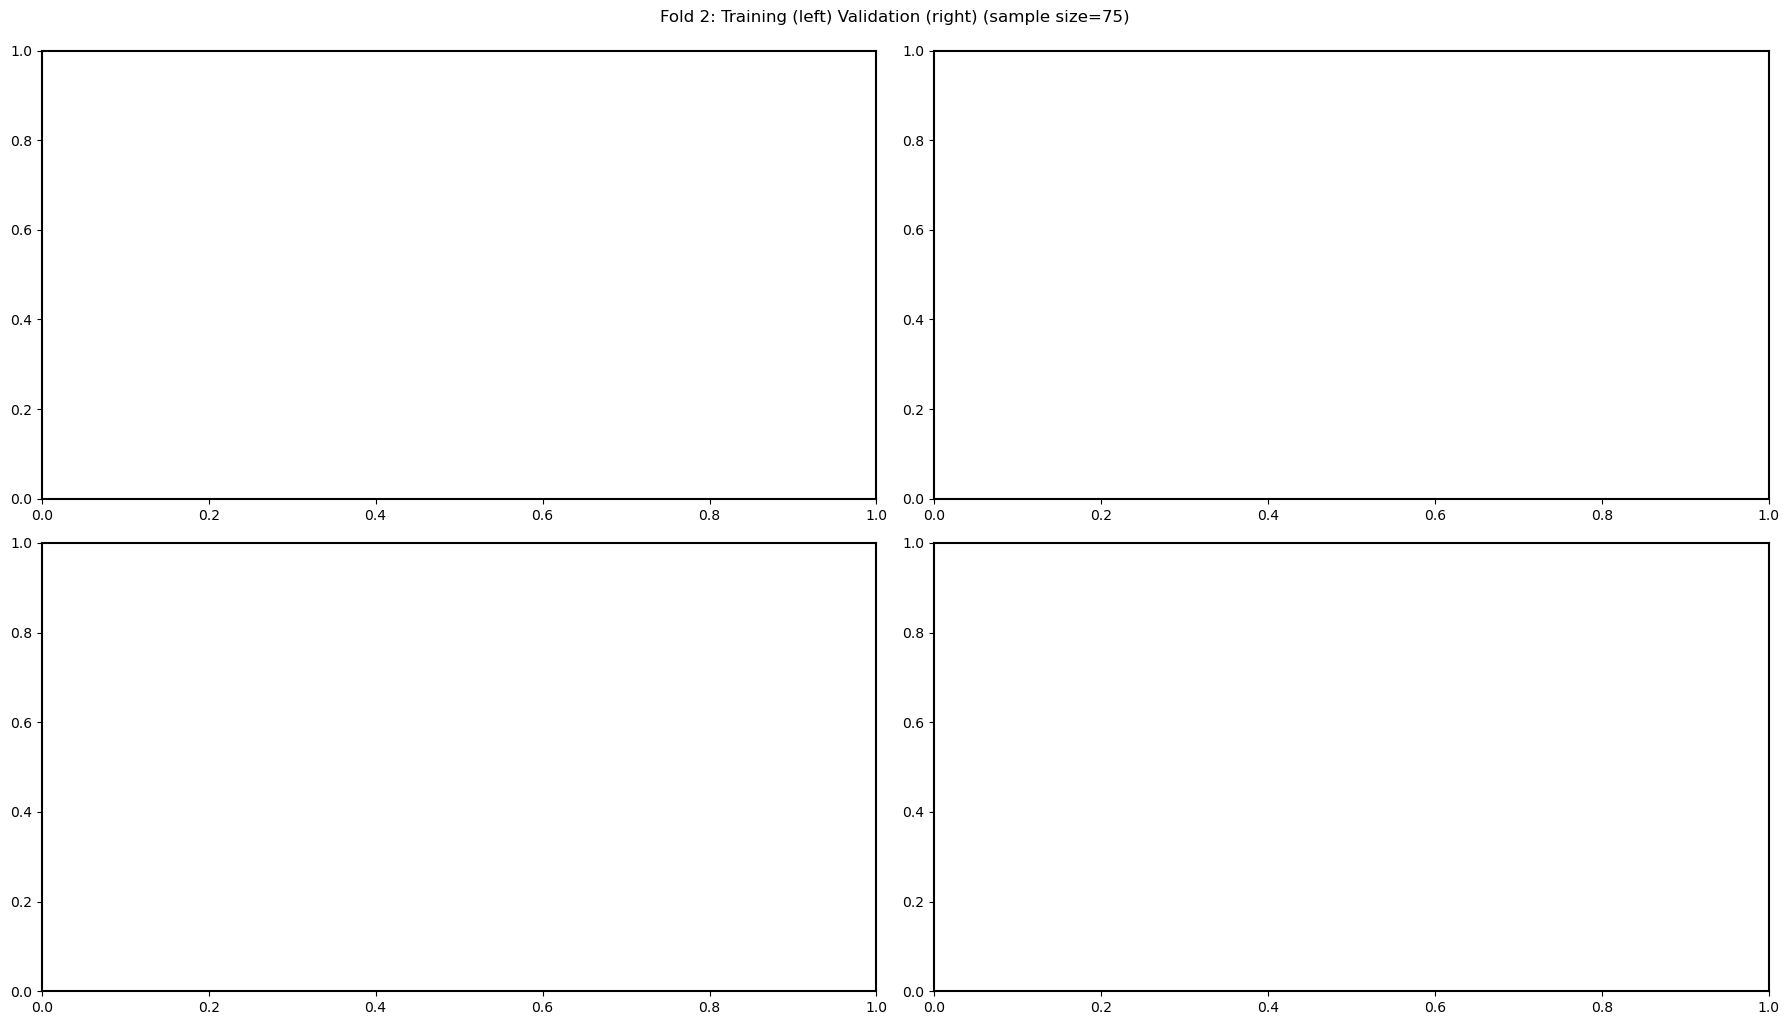

In [7]:
validation_accuracies = do_cross_validation(test_prop, nfolds)

In [39]:
# Train full model

# Training config
learning_rate = 0.001
weight_decay = 1e-5
epochs = 50
gamma = 0.9
batch_size = 128
# momentum=0.9


# train_split_idxs, test_split_idxs, y_train, y_test = train_test_split(
#     all_idxs,
#     y_labels,
#     test_size=test_prop,
#     random_state=42,
#     stratify=y_labels
# )

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_split_idxs)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_split_idxs)
)

# To satisfy train function signature
val_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(np.random.choice(train_split_idxs, size=int(len(train_split_idxs) * 0.05)))
)


# Get dataset stats
print(
    f'test_prop (of dataset) = {100 * len(test_split_idxs) / dataset_size:.2f}%\n'
    f'train_prop (of dataset) = {100 * len(train_split_idxs) / dataset_size:.2f}%\n'
    f'val_prop (of trainset) = {100 * len(val_loader) / (len(val_loader) + len(train_split_idxs)):.2f}%'
)
print_class_dist(dsl, test_split_idxs, 'test')
print_class_dist(dsl, train_split_idxs, 'train')
print_class_dist(dsl, dsl.index, 'overall')


model = CloudDetection()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()


trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=epochs, gamma=gamma, do_summary=True
);
gc.collect();

test_prop (of dataset) = 30.00%
train_prop (of dataset) = 70.00%
val_prop (of trainset) = 0.04%
Percent cloudy (in test) = 53.955% (3765 / 6978); Unique module_ids: [1, 3, 254]
Percent cloudy (in train) = 53.965% (8786 / 16281); Unique module_ids: [1, 3, 254]
Percent cloudy (in overall) = 53.962% (12551 / 23259); Unique module_ids: [1, 3, 254]
torch.Size([128, 2, 32, 32])
(2, 32, 32)
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 28, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 28, 32, 32]          280
|    └─ReLU: 2-2                         [-1, 28, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 28, 32, 32]          56
|    └─Dropout2d: 2-4                    [-1, 28, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 28, 32, 32]          3,556
|    └─ReLU: 2-6                         [-1, 28, 32, 32]          --
|    └─BatchNorm2d: 2-7                  [-1



Epoch 1


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.6886,  acc = 430/814 (52.83%) 



Epoch 2


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.6281,  acc = 664/814 (81.57%) 



Epoch 3


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3998,  acc = 752/814 (92.38%) 



Epoch 4


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3971,  acc = 768/814 (94.35%) 



Epoch 5


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3361,  acc = 770/814 (94.59%) 



Epoch 6


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3470,  acc = 772/814 (94.84%) 



Epoch 7


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3519,  acc = 779/814 (95.70%) 



Epoch 8


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3663,  acc = 778/814 (95.58%) 



Epoch 9


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3479,  acc = 778/814 (95.58%) 



Epoch 10


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3565,  acc = 779/814 (95.70%) 



Epoch 11


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3593,  acc = 777/814 (95.45%) 



Epoch 12


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3544,  acc = 777/814 (95.45%) 



Epoch 13


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3516,  acc = 777/814 (95.45%) 



Epoch 14


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3455,  acc = 779/814 (95.70%) 



Epoch 15


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3670,  acc = 780/814 (95.82%) 



Epoch 16


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3409,  acc = 780/814 (95.82%) 



Epoch 17


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3374,  acc = 784/814 (96.31%) 



Epoch 18


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3307,  acc = 779/814 (95.70%) 



Epoch 19


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3466,  acc = 779/814 (95.70%) 



Epoch 20


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3407,  acc = 779/814 (95.70%) 



Epoch 21


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3461,  acc = 784/814 (96.31%) 



Epoch 22


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3521,  acc = 783/814 (96.19%) 



Epoch 23


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3446,  acc = 785/814 (96.44%) 



Epoch 24


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3427,  acc = 781/814 (95.95%) 



Epoch 25


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3477,  acc = 784/814 (96.31%) 



Epoch 26


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3463,  acc = 780/814 (95.82%) 



Epoch 27


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3531,  acc = 780/814 (95.82%) 



Epoch 28


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3488,  acc = 782/814 (96.07%) 



Epoch 29


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3471,  acc = 779/814 (95.70%) 



Epoch 30


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3429,  acc = 780/814 (95.82%) 



Epoch 31


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3500,  acc = 780/814 (95.82%) 



Epoch 32


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3467,  acc = 778/814 (95.58%) 



Epoch 33


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3441,  acc = 782/814 (96.07%) 



Epoch 34


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3451,  acc = 782/814 (96.07%) 



Epoch 35


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3497,  acc = 782/814 (96.07%) 



Epoch 36


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3579,  acc = 780/814 (95.82%) 



Epoch 37


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3424,  acc = 780/814 (95.82%) 



Epoch 38


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3494,  acc = 779/814 (95.70%) 



Epoch 39


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3436,  acc = 782/814 (96.07%) 



Epoch 40


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3464,  acc = 778/814 (95.58%) 



Epoch 41


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3486,  acc = 780/814 (95.82%) 



Epoch 42


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3464,  acc = 780/814 (95.82%) 



Epoch 43


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3515,  acc = 780/814 (95.82%) 



Epoch 44


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3513,  acc = 779/814 (95.70%) 



Epoch 45


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3347,  acc = 782/814 (96.07%) 



Epoch 46


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3468,  acc = 782/814 (96.07%) 



Epoch 47


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3457,  acc = 783/814 (96.19%) 



Epoch 48


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3400,  acc = 779/814 (95.70%) 



Epoch 49


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3502,  acc = 779/814 (95.70%) 



Epoch 50


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3448,  acc = 779/814 (95.70%) 

Done training


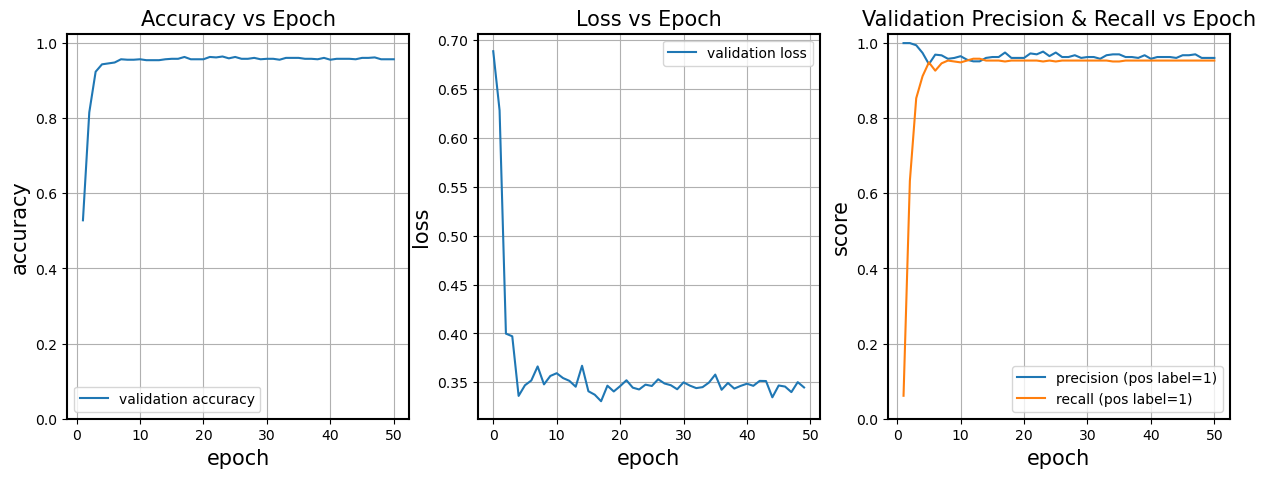

In [40]:
trainer.train(make_train_logs=False)

  0%|          | 0/55 [00:00<?, ?batches/s]

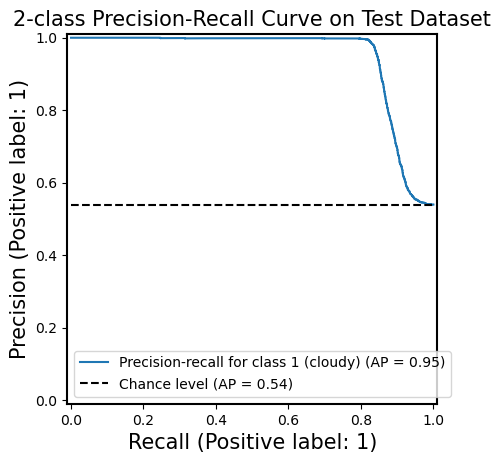

Test: 	loss = 0.3407,  acc = 6717/6978 (96.26%)


In [41]:
test_model = CloudDetection()
test_model.load_state_dict(torch.load('../model_training/best_cloud_detection_model.pth', weights_only=True))
loss_fn = nn.CrossEntropyLoss()
tester = Tester(test_model, loss_fn, test_loader)
tester.eval()